Model Creation Template

0. Import Libraries and Get redshift credentials

In [1]:
import pandas as pd
import numpy as np
from catnip.fla_redshift import FLA_Redshift
from sqlalchemy import null
from datetime import datetime

from prefect.blocks.system import Secret
from typing import Dict
from concurrent.futures import ThreadPoolExecutor

import missingno as msno
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.feature_selection import RFECV
import random
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
def get_redshift_credentials() -> Dict:

    cred_dict = {
        "dbname": Secret.load("stellar-redshift-db-name").get(),
        "host": Secret.load("stellar-redshift-host").get(),
        "port": 5439,
        "user": Secret.load("stellar-redshift-user-name").get(),
        "password": Secret.load("stellar-redshift-password").get(),

        "aws_access_key_id": Secret.load("fla-s3-aws-access-key-id-east-1").get(),
        "aws_secret_access_key": Secret.load("fla-s3-aws-secret-access-key-east-1").get(),
        "bucket": Secret.load("fla-s3-bucket-name-east-1").get(),
        "subdirectory": "us-east-1",

        "verbose": False,
    }

    return cred_dict

with ThreadPoolExecutor(1) as pool:
    rs_creds = pool.submit(lambda: get_redshift_credentials()).result()

1: Missing Data Evaluation

1.1 Import Data

In [4]:
q = """
WITH base_table AS (
    SELECT DISTINCT
        '2023-24'::varchar AS season,
        purch_client_crm_id
    FROM
        custom.cth_v_ticket_subscription_2324
    WHERE
        is_comp = FALSE
    UNION ALL
    SELECT DISTINCT
        '2024-25'::varchar AS season,
        purch_client_crm_id
    FROM
        custom.cth_v_ticket_subscription_2425
    WHERE
        is_comp = FALSE
),
is_local AS (
    SELECT DISTINCT
        clients.crm_id,
        email,
        CASE
            WHEN addresses.is_local = TRUE THEN 1
            ELSE 0
        END AS is_local
    FROM
        custom.seatgeek_v_clients clients
    INNER JOIN
        custom.golden_record_v_addresses addresses USING (email)
),
subscribers AS (
    SELECT DISTINCT
        season::varchar,
        purchaser_ticketing_id,
        MAX(CASE WHEN ticket_type = 'Full' THEN 1 ELSE 0 END) AS "is_full",
        MAX(CASE WHEN ticket_type = 'Premier' OR ticket_type = 'Half' THEN 1 ELSE 0 END) AS "is_premier",
        SUM(gross_revenue) AS "total_spend",
        MAX(CASE WHEN manifest.arena_level_internal = 'Premium' THEN 1 ELSE 0 END) AS "is_premium",
        MAX(CASE WHEN manifest.arena_level_internal = 'Clubs' THEN 1 ELSE 0 END) AS "is_club",
        MAX(CASE WHEN manifest.arena_level_internal = 'Lowers' THEN 1 ELSE 0 END) AS "is_lower",
        MAX(CASE WHEN manifest.arena_level_internal = 'Uppers' THEN 1 ELSE 0 END) AS "is_upper",
        MAX(CASE WHEN is_renewal = TRUE THEN 0 ELSE 1 END) AS "is_rookie"
    FROM
        custom.cth_v_historical_plans ticket
    LEFT JOIN
        custom.cth_v_manifest_base manifest ON ticket.seat_id = manifest.seat_id
    WHERE
        season IN ('2023-24', '2024-25')
    GROUP BY
        season,
        purchaser_ticketing_id
    HAVING
        "total_spend" > 0
),
did_renew AS (
    SELECT DISTINCT
        season::varchar,
        purchaser_ticketing_id,
        CASE
            WHEN purchaser_ticketing_id IN (
                SELECT DISTINCT purchaser_ticketing_id
                FROM custom.cth_v_historical_plans
                WHERE season = '2024-25'
            ) THEN 1
            ELSE 0
        END AS "did_renew"
    FROM
        custom.cth_v_historical_plans
    WHERE
        season = '2023-24'
    UNION ALL
    SELECT DISTINCT
        season::varchar,
        purchaser_ticketing_id,
        CASE
            WHEN purchaser_ticketing_id IN (
                SELECT DISTINCT purchaser_ticketing_id
                FROM custom.cth_v_historical_plans
                WHERE season = '2025-26'
            ) THEN 1
            ELSE 0
        END AS "did_renew"
    FROM
        custom.cth_v_historical_plans
    WHERE
        season = '2024-25'
),
renewal_surveys AS (
    SELECT
        '2023-24'::varchar AS "season",
        contacts.email,
        contacts.primary_ticketing_id,
        MAX(
            CASE how_likely_are_you_to_renew_your_territory_membership_for_next_season
                WHEN 'Extremely Likely' THEN 5
                WHEN 'Likely' THEN 4
                WHEN 'Neutral' THEN 3
                WHEN 'Unlikely' THEN 2
                WHEN 'Extremely Unlikely' THEN 1
                ELSE 0
            END
        ) AS "renewal_likelihood_survey"
    FROM
        custom.formstack_v_stm_renewal_survey_2425 survey
    LEFT JOIN
        custom.korepss_v_contacts contacts ON survey.subscriber_key = contacts.sf_contactid
    GROUP BY
        contacts.email,
        contacts.primary_ticketing_id
    UNION ALL
    SELECT
        '2024-25'::varchar AS "season",
        contacts.email,
        contacts.primary_ticketing_id,
        MAX(
            CASE how_likely_are_you_to_renew_your_territory_membership_for_next_season
                WHEN 'Extremely Likely' THEN 5
                WHEN 'Likely' THEN 4
                WHEN 'Neutral' THEN 3
                WHEN 'Unlikely' THEN 2
                WHEN 'Extremely Unlikely' THEN 1
                ELSE 0
            END
        ) AS "renewal_likelihood_survey"
    FROM
        custom.formstack_v_stm_renewal_survey_2526 survey
    LEFT JOIN
        custom.korepss_v_contacts contacts ON survey.subscriber_key = contacts.sf_contactid
    GROUP BY
        contacts.email,
        contacts.primary_ticketing_id
),
census_income AS (
    WITH temp AS (
        SELECT
            zip,
            CASE
                WHEN median_income BETWEEN 10000 AND 59999 THEN 1
                WHEN median_income BETWEEN 60000 AND 109999 THEN 2
                WHEN median_income BETWEEN 110000 AND 250000 THEN 3
                ELSE 0
            END AS "income_ranking"
        FROM
            custom.census_data_fla
        WHERE
            median_income IS NOT NULL
    ),
    cust AS (
        SELECT DISTINCT
            clients.crm_id,
            email,
            addresses.zip
        FROM
            custom.seatgeek_v_clients clients
        INNER JOIN
            custom.golden_record_v_addresses addresses USING (email)
    )
    SELECT
        cust.crm_id,
        cust.email,
        zip,
        temp.income_ranking
    FROM
        cust
    INNER JOIN
        temp USING (zip)
),
online_contest_entries AS (
    SELECT
        tradable_bits_activities.email,
        crm_id,
        count(tradable_bits_activities.*) AS num_online_activities,
        '2023-24'::varchar AS season
    FROM
        custom.tradable_bits_activities
    LEFT JOIN
        custom.seatgeek_v_clients ON tradable_bits_activities.email = seatgeek_v_clients.email
    WHERE
        creation_date > '2023-07-01'
        AND creation_date < '2024-07-01'
    GROUP BY
        tradable_bits_activities.email,
        crm_id,
        season
    UNION ALL
    SELECT
        tradable_bits_activities.email,
        crm_id,
        count(tradable_bits_activities.*) AS num_online_activities,
        '2024-25'::varchar AS season
    FROM
        custom.tradable_bits_activities
    LEFT JOIN
        custom.seatgeek_v_clients ON tradable_bits_activities.email = seatgeek_v_clients.email
    WHERE
        creation_date > '2024-07-01'
        AND creation_date < '2025-07-01'
    GROUP BY
        tradable_bits_activities.email,
        crm_id,
        season
),
email_engagement AS (
    SELECT
        crm_id,
        num_sent,
        num_opens AS num_opened,
        open_rate,
        num_clicks AS num_clicked,
        num_bounces AS num_bounced,
        CASE
            WHEN date_unsubscribed_panthers IS NOT NULL THEN 1
            ELSE 0
        END AS is_unsubscribed
    FROM
        custom.sfmc_v_subscriber_stats
    LEFT JOIN
        custom.sfmc_v_subscribers ON sfmc_v_subscriber_stats.subscriber_key = sfmc_v_subscribers.subscriber_key
    LEFT JOIN
        custom.seatgeek_v_clients ON sfmc_v_subscribers.email = seatgeek_v_clients.email
),
fla_teamshop AS (
    SELECT
        '2023-24'::varchar AS season,
        flateamshop_v_customer.email,
        crm_id,
        flateamshop_v_order_products.customer_id,
        count(distinct order_id) AS num_orders,
        sum(quantity_sold) AS quantity,
        sum(merch_revenue_itemized) AS merch_rev,
        CASE
            WHEN max(date_created) >= '2024-06-01' THEN 1
            ELSE 0
        END AS purchase_within_month
    FROM
        custom.flateamshop_v_order_products
    LEFT JOIN
        custom.flateamshop_v_customer ON flateamshop_v_order_products.customer_id = flateamshop_v_customer.customer_id
    LEFT JOIN
        custom.seatgeek_v_clients ON flateamshop_v_customer.email = seatgeek_v_clients.email
    WHERE
        creation_date > '2023-07-01'
        AND creation_date < '2024-07-01'
    GROUP BY
        flateamshop_v_customer.email,
        crm_id,
        flateamshop_v_order_products.customer_id
    UNION ALL
    SELECT
        '2024-25'::varchar AS season,
        flateamshop_v_customer.email,
        crm_id,
        flateamshop_v_order_products.customer_id,
        count(distinct order_id) AS num_orders,
        sum(quantity_sold) AS quantity,
        sum(merch_revenue_itemized) AS merch_rev,
        CASE
            WHEN max(date_created) >= dateadd(day, 30, getdate()) THEN 1
            ELSE 0
        END AS purchase_within_month
    FROM
        custom.flateamshop_v_order_products
    LEFT JOIN
        custom.flateamshop_v_customer ON flateamshop_v_order_products.customer_id = flateamshop_v_customer.customer_id
    LEFT JOIN
        custom.seatgeek_v_clients ON flateamshop_v_customer.email = seatgeek_v_clients.email
    WHERE
        creation_date > '2024-07-01'
        AND creation_date < '2025-07-01'
    GROUP BY
        flateamshop_v_customer.email,
        crm_id,
        flateamshop_v_order_products.customer_id
),
yinzcam AS (
    SELECT
        '2023-24'::varchar AS season,
        yinzp.email,
        crm_id,
        SUM(dwell_time) AS total_dwell_time,
        COUNT(DISTINCT session_id) AS num_of_sessions,
        SUM(dwell_time) / COUNT(DISTINCT session_id) AS avg_dwell_time
    FROM
        custom.yinzcam_pvs pv
    LEFT JOIN
        custom.yinzcam_v_profiles yinzp ON pv.yinz_id = yinzp.yinz_id
    LEFT JOIN
        custom.seatgeek_v_clients ON yinzp.email = seatgeek_v_clients.email
    WHERE
        event_timestamp > '2023-07-01'
        AND event_timestamp < '2024-07-01'
    GROUP BY
        yinzp.email,
        crm_id
    UNION ALL
    SELECT
        '2024-25'::varchar AS season,
        yinzp.email,
        crm_id,
        SUM(dwell_time) AS total_dwell_time,
        COUNT(DISTINCT session_id) AS num_of_sessions,
        SUM(dwell_time) / COUNT(DISTINCT session_id) AS avg_dwell_time
    FROM
        custom.yinzcam_pvs pv
    LEFT JOIN
        custom.yinzcam_v_profiles yinzp ON pv.yinz_id = yinzp.yinz_id
    LEFT JOIN
        custom.seatgeek_v_clients ON yinzp.email = seatgeek_v_clients.email
    WHERE
        event_timestamp > '2024-07-01'
        AND event_timestamp < '2025-07-01'
    GROUP BY
        yinzp.email,
        crm_id
),
demo_data AS (
    SELECT
        seatgeek_v_clients.email,
        crm_id,
        age,
        CASE
            WHEN golden_record_v_demo_profile.gender = 'Male' THEN 1
            ELSE 0
        END AS is_male,
        CASE
            WHEN golden_record_v_demo_profile.gender = 'Female' THEN 1
            ELSE 0
        END AS is_female,
        CASE
            WHEN golden_record_v_demo_profile.gender = 'Non-Binary' THEN 1
            ELSE 0
        END AS is_nonbinary,
        CASE
            WHEN golden_record_v_demo_profile.marital_status = 'Married' THEN 1
            ELSE 0
        END AS is_married,
        CASE
            WHEN golden_record_v_demo_profile.marital_status = 'Single' THEN 1
            ELSE 0
        END AS is_single,
        CASE
            WHEN golden_record_v_demo_profile.marital_status = 'Divorced/separated' THEN 1
            ELSE 0
        END AS is_divorced_separated,
        CASE
            WHEN golden_record_v_demo_profile.marital_status = 'Dating/In a Relationship' THEN 1
            ELSE 0
        END AS is_dating,
        CASE
            WHEN golden_record_v_demo_profile.marital_status = 'Widowed' THEN 1
            ELSE 0
        END AS is_widowed,
        num_children_at_home::int,
        CASE
            WHEN golden_record_v_demo_profile.household_income = 'Less than $50,000' THEN 1
            WHEN golden_record_v_demo_profile.household_income = '$50,000-$99,999' THEN 2
            WHEN golden_record_v_demo_profile.household_income = '$100,000-$174,999' THEN 3
            WHEN golden_record_v_demo_profile.household_income = '$175,000-$249,999' THEN 4
            WHEN golden_record_v_demo_profile.household_income = '$250,000-$499,999' THEN 5
            WHEN golden_record_v_demo_profile.household_income = '$500,000+' THEN 6
        END AS household_income,
        CASE
            WHEN golden_record_v_demo_profile.education = 'Less Than High School' THEN 1
            WHEN golden_record_v_demo_profile.education = 'High School Graduate' THEN 2
            WHEN golden_record_v_demo_profile.education = 'Some College' THEN 3
            WHEN golden_record_v_demo_profile.education = 'College Graduate' THEN 4
            WHEN golden_record_v_demo_profile.education = 'Graduate Or Professional Degree' THEN 5
        END AS education
    FROM
        custom.golden_record_v_demo_profile
    LEFT JOIN
        custom.seatgeek_v_clients ON golden_record_v_demo_profile.email = seatgeek_v_clients.email
),
community_data AS (
    WITH unioned_community_table_2324 AS (
        SELECT
            DISTINCT parent_email
        FROM
            custom.community_v_kidsclub
        WHERE
            season <= '2023-24'
        UNION ALL
        SELECT
            DISTINCT parent_email
        FROM
            custom.community_v_ltp
        WHERE
            season <= '2023-24'
        UNION ALL
        SELECT
            DISTINCT parent_email
        FROM
            custom.community_v_pe_floorball
        WHERE
            season <= '2023-24'
        UNION ALL
        SELECT
            DISTINCT parent_email
        FROM
            custom.community_v_ltp_ball_hockey
        WHERE
            season <= '2023-24'
        UNION ALL
        SELECT
            DISTINCT email AS parent_email
        FROM
            custom.community_v_altp
        WHERE
            season <= '2023-24'
    ),
    unioned_community_table_2425 AS (
        SELECT
            DISTINCT parent_email
        FROM
            custom.community_v_kidsclub
        WHERE
            season <= '2024-25'
        UNION ALL
        SELECT
            DISTINCT parent_email
        FROM
            custom.community_v_ltp
        WHERE
            season <= '2024-25'
        UNION ALL
        SELECT
            DISTINCT parent_email
        FROM
            custom.community_v_pe_floorball
        WHERE
            season <= '2024-25'
        UNION ALL
        SELECT
            DISTINCT parent_email
        FROM
            custom.community_v_ltp_ball_hockey
        WHERE
            season <= '2024-25'
        UNION ALL
        SELECT
            DISTINCT email AS parent_email
        FROM
            custom.community_v_altp
        WHERE
            season <= '2024-25'
    )
    SELECT
        '2023-24'::varchar AS season,
        unioned_community_table_2324.*,
        crm_id
    FROM
        unioned_community_table_2324
    LEFT JOIN
        custom.seatgeek_v_clients ON unioned_community_table_2324.parent_email = seatgeek_v_clients.email
    UNION ALL
    SELECT
        '2024-25'::varchar AS season,
        unioned_community_table_2425.*,
        crm_id
    FROM
        unioned_community_table_2425
    LEFT JOIN
        custom.seatgeek_v_clients ON unioned_community_table_2425.parent_email = seatgeek_v_clients.email
),
discount_data AS (
    WITH cheq_discounts_2324 AS (
        SELECT DISTINCT
            seatgeek_v_clients.email,
            crm_id,
            discount_name AS cheq_discount_name
        FROM
            custom.cheq_v_tracked_transactions_lookup
        INNER JOIN
            custom.cheq_v_tracked_transactions_discounts
            ON cheq_v_tracked_transactions_lookup.order_id = cheq_v_tracked_transactions_discounts.order_id
        LEFT JOIN
            custom.cheq_v_order_items
            ON cheq_v_order_items.order_id = cheq_v_tracked_transactions_lookup.order_id
        LEFT JOIN
            custom.seatgeek_v_clients
            ON cheq_v_tracked_transactions_lookup.email = seatgeek_v_clients.email
        WHERE
            created_at_est > '2023-07-01'
            AND created_at_est < '2024-07-01'
    ),
    retailpro_discounts_2324 AS (
        SELECT DISTINCT
            retailpro_v_tracked_transactions_lookup.email,
            crm_id,
            discount_name AS retailpro_discount_name
        FROM
            custom.retailpro_v_tracked_transactions_lookup
        INNER JOIN
            custom.retailpro_v_tracked_transactions_discounts
            ON retailpro_v_tracked_transactions_lookup.invoice_id = retailpro_v_tracked_transactions_discounts.invoice_id
        LEFT JOIN
            custom.seatgeek_v_clients
            ON retailpro_v_tracked_transactions_lookup.email = seatgeek_v_clients.email
        LEFT JOIN
            custom.retailpro_v_invoice_items
            ON retailpro_v_invoice_items.invoice_id = retailpro_v_tracked_transactions_lookup.invoice_id
        WHERE
            transaction_timestamp > '2023-07-01'
            AND transaction_timestamp < '2024-07-01'
    ),
    cheq_discounts_2425 AS (
        SELECT DISTINCT
            seatgeek_v_clients.email,
            crm_id,
            discount_name AS cheq_discount_name
        FROM
            custom.cheq_v_tracked_transactions_lookup
        INNER JOIN
            custom.cheq_v_tracked_transactions_discounts
            ON cheq_v_tracked_transactions_lookup.order_id = cheq_v_tracked_transactions_discounts.order_id
        LEFT JOIN
            custom.cheq_v_order_items
            ON cheq_v_order_items.order_id = cheq_v_tracked_transactions_lookup.order_id
        LEFT JOIN
            custom.seatgeek_v_clients
            ON cheq_v_tracked_transactions_lookup.email = seatgeek_v_clients.email
        WHERE
            created_at_est < '2024-07-01'
            AND created_at_est < '2025-07-01'
    ),
    retailpro_discounts_2425 AS (
        SELECT DISTINCT
            retailpro_v_tracked_transactions_lookup.email,
            crm_id,
            discount_name AS retailpro_discount_name
        FROM
            custom.retailpro_v_tracked_transactions_lookup
        INNER JOIN
            custom.retailpro_v_tracked_transactions_discounts
            ON retailpro_v_tracked_transactions_lookup.invoice_id = retailpro_v_tracked_transactions_discounts.invoice_id
        LEFT JOIN
            custom.seatgeek_v_clients
            ON retailpro_v_tracked_transactions_lookup.email = seatgeek_v_clients.email
        LEFT JOIN
            custom.retailpro_v_invoice_items
            ON retailpro_v_invoice_items.invoice_id = retailpro_v_tracked_transactions_lookup.invoice_id
        WHERE
            transaction_timestamp < '2024-07-01'
            AND transaction_timestamp < '2025-07-01'
    )
    SELECT
        '2023-24'::varchar AS season,
        COALESCE(cheq_discounts_2324.email, retailpro_discounts_2324.email) AS final_email,
        COALESCE(cheq_discounts_2324.crm_id, retailpro_discounts_2324.crm_id) AS crm,
        CASE WHEN listagg(retailpro_discount_name) IS NOT NULL THEN 1 ELSE 0 END AS retailpro_discount,
        CASE WHEN listagg(cheq_discount_name) IS NOT NULL THEN 1 ELSE 0 END AS cheq_discount
    FROM
        cheq_discounts_2324
    FULL OUTER JOIN
        retailpro_discounts_2324
        ON cheq_discounts_2324.crm_id = retailpro_discounts_2324.crm_id
    GROUP BY
        final_email,
        crm
    UNION ALL
    SELECT
        '2024-25'::varchar AS season,
        COALESCE(cheq_discounts_2425.email, retailpro_discounts_2425.email) AS final_email,
        COALESCE(cheq_discounts_2425.crm_id, retailpro_discounts_2425.crm_id) AS crm,
        CASE WHEN listagg(retailpro_discount_name) IS NOT NULL THEN 1 ELSE 0 END AS retailpro_discount,
        CASE WHEN listagg(cheq_discount_name) IS NOT NULL THEN 1 ELSE 0 END AS cheq_discount
    FROM
        cheq_discounts_2425
    FULL OUTER JOIN
        retailpro_discounts_2425
        ON cheq_discounts_2425.crm_id = retailpro_discounts_2425.crm_id
    GROUP BY
        final_email,
        crm
),
attendance_data AS (
    WITH avg_entry_time AS (
        SELECT
            '2024-25'::varchar AS season,
            client_crm_id_scan,
            AVG(time_bucket) AS avg_entry_time
        FROM
            custom.cth_v_attendance_2425
        GROUP BY
            client_crm_id_scan
        UNION ALL
        SELECT
            '2023-24'::varchar AS season,
            client_crm_id_scan,
            AVG(time_bucket) AS avg_entry_time
        FROM
            custom.cth_v_attendance_2324
        GROUP BY
            client_crm_id_scan
    )
    SELECT
        cth_v_show_rates.season::varchar,
        ticketing_id,
        num_games_attended,
        self_show_rate,
        seat_show_rate,
        real_show_rate,
        avg_entry_time
    FROM
        custom.cth_v_show_rates
    LEFT JOIN
        avg_entry_time
        ON cth_v_show_rates.ticketing_id = avg_entry_time.client_crm_id_scan
        AND cth_v_show_rates.season = avg_entry_time.season
    WHERE
        cth_v_show_rates.season IN ('2023-24', '2024-25')
)
SELECT DISTINCT
    base_table.season,
    base_table.purch_client_crm_id,
    census_income.income_ranking,
    renewal_surveys.renewal_likelihood_survey,
    did_renew.did_renew,
    subscribers.is_upper,
    subscribers.is_rookie,
    subscribers.is_lower,
    subscribers.is_full,
    subscribers.is_club,
    subscribers.is_premier,
    subscribers.is_premium,
    subscribers.total_spend,
    is_local.is_local,
    online_contest_entries.num_online_activities,
    email_engagement.num_sent,
    email_engagement.num_opened,
    COALESCE(email_engagement.open_rate, 0) AS open_rate,
    email_engagement.num_clicked,
    email_engagement.num_bounced,
    email_engagement.is_unsubscribed,
    fla_teamshop.merch_rev,
    fla_teamshop.purchase_within_month,
    fla_teamshop.num_orders,
    fla_teamshop.quantity,
    yinzcam.total_dwell_time,
    yinzcam.num_of_sessions,
    yinzcam.avg_dwell_time,
    demo_data.is_male,
    demo_data.is_female,
    demo_data.is_nonbinary,
    demo_data.age,
    demo_data.is_married,
    demo_data.is_single,
    demo_data.is_divorced_separated,
    demo_data.is_dating,
    demo_data.is_widowed,
    demo_data.num_children_at_home,
    demo_data.household_income,
    demo_data.education,
    CASE
        WHEN community_data.crm_id IS NOT NULL THEN 1
        ELSE 0
    END AS is_community,
    discount_data.cheq_discount,
    discount_data.retailpro_discount,
    attendance_data.num_games_attended,
    attendance_data.seat_show_rate,
    attendance_data.self_show_rate,
    attendance_data.real_show_rate,
    attendance_data.avg_entry_time
FROM
    base_table
LEFT JOIN
    census_income
    ON base_table.purch_client_crm_id = census_income.crm_id
LEFT JOIN
    renewal_surveys
    ON base_table.purch_client_crm_id = renewal_surveys.primary_ticketing_id
    AND base_table.season::varchar = renewal_surveys.season::varchar
LEFT JOIN
    did_renew
    ON base_table.purch_client_crm_id = did_renew.purchaser_ticketing_id
    AND base_table.season::varchar = did_renew.season::varchar
LEFT JOIN
    subscribers
    ON base_table.purch_client_crm_id = subscribers.purchaser_ticketing_id
    AND base_table.season::varchar = subscribers.season::varchar
LEFT JOIN
    is_local
    ON base_table.purch_client_crm_id = is_local.crm_id
LEFT JOIN
    online_contest_entries
    ON base_table.purch_client_crm_id = online_contest_entries.crm_id
    AND base_table.season::varchar = online_contest_entries.season::varchar
LEFT JOIN
    email_engagement
    ON base_table.purch_client_crm_id = email_engagement.crm_id
LEFT JOIN
    fla_teamshop
    ON base_table.purch_client_crm_id = fla_teamshop.crm_id
    AND base_table.season::varchar = fla_teamshop.season::varchar
LEFT JOIN
    yinzcam
    ON base_table.purch_client_crm_id = yinzcam.crm_id
    AND base_table.season::varchar = yinzcam.season::varchar
LEFT JOIN
    demo_data
    ON base_table.purch_client_crm_id = demo_data.crm_id
LEFT JOIN
    community_data
    ON base_table.purch_client_crm_id = community_data.crm_id
    AND base_table.season::varchar = community_data.season::varchar
LEFT JOIN
    discount_data
    ON base_table.purch_client_crm_id = discount_data.crm
    AND base_table.season::varchar = discount_data.season::varchar
LEFT JOIN
    attendance_data
    ON base_table.purch_client_crm_id = attendance_data.ticketing_id
    AND base_table.season::varchar = attendance_data.season::varchar
"""

df_all = FLA_Redshift(**rs_creds).query_warehouse(sql_string = q)

In [ ]:
# get 24-25 Premier data

q = """
WITH zip AS (
    SELECT
        purch_client_crm_id,
        seatgeek_v_clients.email,
        bool_or(is_local) AS is_local
    FROM
        custom.cth_v_ticket_subscription_2425
    LEFT JOIN
        custom.seatgeek_v_clients ON cth_v_ticket_subscription_2425.purch_client_crm_id = seatgeek_v_clients.crm_id
    LEFT JOIN
        custom.golden_record_v_addresses ON seatgeek_v_clients.email = golden_record_v_addresses.email
    WHERE
        ticket_type IN ('Premier')
        and price_type not ilike '%comp%'
    GROUP BY
        purch_client_crm_id,
        seatgeek_v_clients.email
),
touchpoints AS (
    SELECT DISTINCT
        a.sf_contactid
    FROM
        custom.korepss_contacts a
    WHERE
        a.contacttype = 'Member'
),
touchpoints_agg AS (
    SELECT
        a.primary_ticketing_id,
        d.last_activity_date_new__c,
        COUNT(DISTINCT act.activityid) AS touchpoints
    FROM
        custom.korepss_v_contacts a
        LEFT JOIN custom.korepss_contacts b ON a.sf_contactid = b.sf_contactid
        LEFT JOIN custom.korepss_accounts_extension d ON a.sf_accountid = d.sf_accountid
        LEFT JOIN custom.korepss_v_users c ON b.ticketing_service_rep = c.sf_userid
        LEFT JOIN custom.korepss_v_activities act ON a.sf_contactid = act.contactid AND b.ticketing_service_rep = act.ownerid
    WHERE
        a.sf_contactid IN (SELECT sf_contactid FROM touchpoints)
        AND act.completed_on_coalesce >= '7/1/2024'
    GROUP BY
        a.primary_ticketing_id,
        d.last_activity_date_new__c
),
tenure AS (
    SELECT
        purchaser_ticketing_id,
        LISTAGG(DISTINCT season),
        CASE
            WHEN LISTAGG(DISTINCT season) LIKE '2021-222022-232023-242024-25' THEN 4
            WHEN LISTAGG(DISTINCT season) LIKE '2022-232023-242024-25' THEN 3
            WHEN LISTAGG(DISTINCT season) LIKE '2023-242024-25' THEN 2
            WHEN LISTAGG(DISTINCT season) LIKE '%2024-25%' THEN 1
            ELSE 0
        END AS tenure
    FROM
        custom.cth_v_historical_ticket
    WHERE
        ticket_type IN ('Premier')
        AND section_name != 'Panther Bar'
    GROUP BY
        purchaser_ticketing_id
),
attendance_info AS (
    SELECT
        ticketing_id,
        num_games_attended,
        self_show_rate,
        seat_show_rate,
        real_show_rate
    FROM
        custom.cth_v_show_rates
    WHERE
        season = '2024-25'
),
total_spend AS (
    SELECT
        purchaser_ticketing_id,
        SUM(gross_revenue) AS gross_revenue
    FROM
        custom.cth_v_historical_ticket
    WHERE
        season = '2024-25'
    GROUP BY
        purchaser_ticketing_id
),
location_ticket_type AS (
    SELECT
        purchaser_ticketing_id,
        ticket_type,
        arena_level_internal,
        COUNT(*) AS num_tickets
    FROM
        custom.cth_v_historical_ticket
    WHERE
        ticket_type IN ('Premier')
        AND season = '2024-25'
    GROUP BY
        purchaser_ticketing_id,
        ticket_type,
        arena_level_internal
),
location_ticket_type_agg AS (
    SELECT
        purchaser_ticketing_id,
        arena_level_internal
    FROM
        (SELECT
             purchaser_ticketing_id,
             arena_level_internal,
             ROW_NUMBER() OVER (PARTITION BY purchaser_ticketing_id ORDER BY num_tickets DESC,
                 CASE arena_level_internal
                     WHEN 'Premium' THEN 1
                     WHEN 'Lower' THEN 2
                     WHEN 'Club' THEN 3
                     ELSE 4
                 END) AS rn
         FROM
             location_ticket_type)
    WHERE rn = 1
),
renewal_survey AS (
    SELECT
        formstack_v_stm_renewal_survey_2526.email,
        crm_id,
        MAX(CASE how_likely_are_you_to_renew_your_territory_membership_for_next_season
            WHEN 'Extremely Likely' THEN 3
            WHEN 'Likely' THEN 2
            WHEN 'Neutral' THEN 1
            WHEN 'Unlikely' THEN -1
            WHEN 'Extremely Unlikely' THEN -2
            ELSE 0
        END) AS renewal_likelihood_survey
    FROM
        custom.formstack_v_stm_renewal_survey_2526
    LEFT JOIN
        custom.seatgeek_v_clients on formstack_v_stm_renewal_survey_2526.email = seatgeek_v_clients.email
    GROUP BY
        formstack_v_stm_renewal_survey_2526.email,
        crm_id
)
SELECT DISTINCT
    zip.purch_client_crm_id,
    zip.email,
    CASE
        WHEN zip.is_local = TRUE THEN 1
        ELSE 0
    END AS is_local,
    COALESCE(touchpoints_agg.touchpoints, 0) AS touchpoints,
    tenure.tenure,
    attendance_info.real_show_rate,
    attendance_info.seat_show_rate,
    attendance_info.self_show_rate,
    attendance_info.num_games_attended,
    total_spend.gross_revenue,
    CASE
        WHEN location_ticket_type_agg.arena_level_internal = 'Premium' THEN 1
        WHEN location_ticket_type_agg.arena_level_internal = 'Lowers' THEN 2
        WHEN location_ticket_type_agg.arena_level_internal = 'Clubs' THEN 3
        WHEN location_ticket_type_agg.arena_level_internal = 'Uppers' THEN 4
    END AS arena_level_internal,
    coalesce(renewal_likelihood_survey, 0) as renewal_likelihood_survey
FROM
    zip
LEFT JOIN
    touchpoints_agg 
        ON zip.purch_client_crm_id = touchpoints_agg.primary_ticketing_id
LEFT JOIN
    tenure 
        ON zip.purch_client_crm_id = tenure.purchaser_ticketing_id
LEFT JOIN
    attendance_info 
        ON zip.purch_client_crm_id = attendance_info.ticketing_id
LEFT JOIN
    total_spend 
        ON zip.purch_client_crm_id = total_spend.purchaser_ticketing_id
LEFT JOIN
    location_ticket_type_agg 
        ON zip.purch_client_crm_id = location_ticket_type_agg.purchaser_ticketing_id
LEFT JOIN
    renewal_survey 
        ON zip.purch_client_crm_id = renewal_survey.crm_id
WHERE
    total_spend.gross_revenue > 0
"""

#df_premier_2425 = FLA_Redshift(**rs_creds).query_warehouse(sql_string = q)

In [ ]:
# get 24-25 Full data

q = """
WITH zip AS (
    SELECT
        purch_client_crm_id,
        seatgeek_v_clients.email,
        bool_or(is_local) AS is_local
    FROM
        custom.cth_v_ticket_subscription_2425
    LEFT JOIN
        custom.seatgeek_v_clients ON cth_v_ticket_subscription_2425.purch_client_crm_id = seatgeek_v_clients.crm_id
    LEFT JOIN
        custom.golden_record_v_addresses ON seatgeek_v_clients.email = golden_record_v_addresses.email
    WHERE
        ticket_type IN ('Full')
        and price_type not ilike '%comp%'
    GROUP BY
        purch_client_crm_id,
        seatgeek_v_clients.email
),
touchpoints AS (
    SELECT DISTINCT
        a.sf_contactid
    FROM
        custom.korepss_contacts a
    WHERE
        a.contacttype = 'Member'
),
touchpoints_agg AS (
    SELECT
        a.primary_ticketing_id,
        d.last_activity_date_new__c,
        COUNT(DISTINCT act.activityid) AS touchpoints
    FROM
        custom.korepss_v_contacts a
        LEFT JOIN custom.korepss_contacts b ON a.sf_contactid = b.sf_contactid
        LEFT JOIN custom.korepss_accounts_extension d ON a.sf_accountid = d.sf_accountid
        LEFT JOIN custom.korepss_v_users c ON b.ticketing_service_rep = c.sf_userid
        LEFT JOIN custom.korepss_v_activities act ON a.sf_contactid = act.contactid AND b.ticketing_service_rep = act.ownerid
    WHERE
        a.sf_contactid IN (SELECT sf_contactid FROM touchpoints)
        AND act.completed_on_coalesce >= '7/1/2024'
    GROUP BY
        a.primary_ticketing_id,
        d.last_activity_date_new__c
),
tenure AS (
    SELECT
        purchaser_ticketing_id,
        LISTAGG(DISTINCT season),
        CASE
            WHEN LISTAGG(DISTINCT season) LIKE '2021-222022-232023-242024-25' THEN 4
            WHEN LISTAGG(DISTINCT season) LIKE '2022-232023-242024-25' THEN 3
            WHEN LISTAGG(DISTINCT season) LIKE '2023-242024-25' THEN 2
            WHEN LISTAGG(DISTINCT season) LIKE '%2024-25%' THEN 1
            ELSE 0
        END AS tenure
    FROM
        custom.cth_v_historical_ticket
    WHERE
        ticket_type IN ('Full')
        AND section_name != 'Panther Bar'
    GROUP BY
        purchaser_ticketing_id
),
attendance_info AS (
    SELECT
        ticketing_id,
        num_games_attended,
        self_show_rate,
        seat_show_rate,
        real_show_rate
    FROM
        custom.cth_v_show_rates
    WHERE
        season = '2024-25'
),
total_spend AS (
    SELECT
        purchaser_ticketing_id,
        SUM(gross_revenue) AS gross_revenue
    FROM
        custom.cth_v_historical_ticket
    WHERE
        season = '2024-25'
    GROUP BY
        purchaser_ticketing_id
),
location_ticket_type AS (
    SELECT
        purchaser_ticketing_id,
        ticket_type,
        arena_level_internal,
        COUNT(*) AS num_tickets
    FROM
        custom.cth_v_historical_ticket
    WHERE
        ticket_type IN ('Full')
        AND season = '2024-25'
    GROUP BY
        purchaser_ticketing_id,
        ticket_type,
        arena_level_internal
),
location_ticket_type_agg AS (
    SELECT
        purchaser_ticketing_id,
        arena_level_internal
    FROM
        (SELECT
             purchaser_ticketing_id,
             arena_level_internal,
             ROW_NUMBER() OVER (PARTITION BY purchaser_ticketing_id ORDER BY num_tickets DESC,
                 CASE arena_level_internal
                     WHEN 'Premium' THEN 1
                     WHEN 'Lower' THEN 2
                     WHEN 'Club' THEN 3
                     ELSE 4
                 END) AS rn
         FROM
             location_ticket_type)
    WHERE rn = 1
),
renewal_survey AS (
    SELECT
        formstack_v_stm_renewal_survey_2526.email,
        crm_id,
        MAX(CASE how_likely_are_you_to_renew_your_territory_membership_for_next_season
            WHEN 'Extremely Likely' THEN 3
            WHEN 'Likely' THEN 2
            WHEN 'Neutral' THEN 1
            WHEN 'Unlikely' THEN -1
            WHEN 'Extremely Unlikely' THEN -2
            ELSE 0
        END) AS renewal_likelihood_survey
    FROM
        custom.formstack_v_stm_renewal_survey_2526
    LEFT JOIN
        custom.seatgeek_v_clients on formstack_v_stm_renewal_survey_2526.email = seatgeek_v_clients.email
    GROUP BY
        formstack_v_stm_renewal_survey_2526.email,
        crm_id
)
SELECT DISTINCT
    zip.purch_client_crm_id,
    zip.email,
    CASE
        WHEN zip.is_local = TRUE THEN 1
        ELSE 0
    END AS is_local,
    COALESCE(touchpoints_agg.touchpoints, 0) AS touchpoints,
    tenure.tenure,
    attendance_info.real_show_rate,
    attendance_info.seat_show_rate,
    attendance_info.self_show_rate,
    attendance_info.num_games_attended,
    total_spend.gross_revenue,
    CASE
        WHEN location_ticket_type_agg.arena_level_internal = 'Premium' THEN 1
        WHEN location_ticket_type_agg.arena_level_internal = 'Lowers' THEN 2
        WHEN location_ticket_type_agg.arena_level_internal = 'Clubs' THEN 3
        WHEN location_ticket_type_agg.arena_level_internal = 'Uppers' THEN 4
    END AS arena_level_internal,
    coalesce(renewal_likelihood_survey, 0) as renewal_likelihood_survey
FROM
    zip
LEFT JOIN
    touchpoints_agg 
        ON zip.purch_client_crm_id = touchpoints_agg.primary_ticketing_id
LEFT JOIN
    tenure 
        ON zip.purch_client_crm_id = tenure.purchaser_ticketing_id
LEFT JOIN
    attendance_info 
        ON zip.purch_client_crm_id = attendance_info.ticketing_id
LEFT JOIN
    total_spend 
        ON zip.purch_client_crm_id = total_spend.purchaser_ticketing_id
LEFT JOIN
    location_ticket_type_agg 
        ON zip.purch_client_crm_id = location_ticket_type_agg.purchaser_ticketing_id
LEFT JOIN
    renewal_survey 
        ON zip.purch_client_crm_id = renewal_survey.crm_id
WHERE
    total_spend.gross_revenue > 0
    and zip.email not ilike '%floridapanthers%'
    and zip.email not ilike '%amerantbank%'
"""

#df_full_2425 = FLA_Redshift(**rs_creds).query_warehouse(sql_string = q)

In [ ]:
# get 23-24 Premier data

q = """
WITH zip AS (
    SELECT
        purch_client_crm_id,
        seatgeek_v_clients.email,
        bool_or(is_local) AS is_local
    FROM
        custom.cth_v_ticket_subscription_2324
    LEFT JOIN
        custom.seatgeek_v_clients ON cth_v_ticket_subscription_2324.purch_client_crm_id = seatgeek_v_clients.crm_id
    LEFT JOIN
        custom.golden_record_v_addresses ON seatgeek_v_clients.email = golden_record_v_addresses.email
    WHERE
        ticket_type IN ('Premier')
        and price_type not ilike '%comp%'
    GROUP BY
        purch_client_crm_id,
        seatgeek_v_clients.email
),
touchpoints AS (
    SELECT
        DISTINCT a.sf_contactid
    FROM
        custom.korepss_contacts a
    WHERE
        a.contacttype = 'Member'
),
touchpoints_agg AS (
    SELECT
        a.primary_ticketing_id,
        d.last_activity_date_new__c,
        COUNT(DISTINCT act.activityid) AS touchpoints
    FROM
        custom.korepss_v_contacts a
        LEFT JOIN custom.korepss_contacts b ON a.sf_contactid = b.sf_contactid
        LEFT JOIN custom.korepss_accounts_extension d ON a.sf_accountid = d.sf_accountid
        LEFT JOIN custom.korepss_v_users c ON b.ticketing_service_rep = c.sf_userid
        LEFT JOIN custom.korepss_v_activities act ON a.sf_contactid = act.contactid AND b.ticketing_service_rep = act.ownerid
    WHERE
        a.sf_contactid IN (SELECT sf_contactid FROM touchpoints)
        AND act.completed_on_coalesce >= '7/1/2023'
        AND act.completed_on_coalesce < '7/1/2024'
    GROUP BY
        a.primary_ticketing_id,
        d.last_activity_date_new__c
),
tenure AS (
    SELECT
        purchaser_ticketing_id,
        LISTAGG(DISTINCT season),
        CASE
            WHEN LISTAGG(DISTINCT season) LIKE '2021-222022-232023-24' THEN 3
            WHEN LISTAGG(DISTINCT season) LIKE '2022-232023-24' THEN 2
            WHEN LISTAGG(DISTINCT season) LIKE '%2023-24%' THEN 1
            ELSE 0
        END AS tenure
    FROM
        custom.cth_v_historical_ticket
    WHERE
        ticket_type IN ('Premier')
        AND section_name != 'Panther Bar'
    GROUP BY
        purchaser_ticketing_id
),
attendance_info AS (
    SELECT
        ticketing_id,
        num_games_attended,
        self_show_rate,
        seat_show_rate,
        real_show_rate
    FROM
        custom.cth_v_show_rates
    WHERE
        season = '2023-24'
),
total_spend AS (
    SELECT
        purchaser_ticketing_id,
        SUM(gross_revenue) AS gross_revenue
    FROM
        custom.cth_v_historical_ticket
    WHERE
        season = '2023-24'
    GROUP BY
        purchaser_ticketing_id
),
location_ticket_type AS (
    SELECT
        purchaser_ticketing_id,
        ticket_type,
        arena_level_internal,
        count(*) as num_tickets
    FROM
        custom.cth_v_historical_ticket
    WHERE
        ticket_type IN ('Premier')
        AND season = '2023-24'
    GROUP BY
        purchaser_ticketing_id,
        ticket_type,
        arena_level_internal
),
location_ticket_type_agg as (
    SELECT
        purchaser_ticketing_id,
        arena_level_internal
    FROM
        (SELECT
             purchaser_ticketing_id,
             arena_level_internal,
             ROW_NUMBER() OVER (PARTITION BY purchaser_ticketing_id ORDER BY num_tickets DESC,
                 CASE arena_level_internal WHEN 'Premium' THEN 1 WHEN 'Lower' THEN 2 WHEN 'Club' THEN 3 ELSE 4 END) AS rn
         FROM
             location_ticket_type)
    WHERE rn = 1
),
did_renew AS (
    SELECT
        subs_2324.purch_client_crm_id,
        CASE
            WHEN subs_2425.purch_client_crm_id IS NULL THEN 0
            ELSE 1
        END AS did_renew
    FROM
        custom.cth_v_ticket_subscription_2324 subs_2324
    LEFT JOIN
        custom.cth_v_ticket_subscription_2425 subs_2425 ON subs_2324.purch_client_crm_id = subs_2425.purch_client_crm_id
    GROUP BY
        subs_2425.purch_client_crm_id,
        subs_2324.purch_client_crm_id
),
renewal_survey AS (
    SELECT
        formstack_v_stm_renewal_survey_2425.email,
        crm_id,
        MAX(CASE how_likely_are_you_to_renew_your_territory_membership_for_next_season
            WHEN 'Extremely Likely' THEN 3
            WHEN 'Likely' THEN 2
            WHEN 'Neutral' THEN 1
            WHEN 'Unlikely' THEN -1
            WHEN 'Extremely Unlikely' THEN -2
            ELSE 0
        END) AS renewal_likelihood_survey
    FROM
        custom.formstack_v_stm_renewal_survey_2425
    LEFT JOIN
        custom.seatgeek_v_clients on formstack_v_stm_renewal_survey_2425.email = seatgeek_v_clients.email
    GROUP BY
        formstack_v_stm_renewal_survey_2425.email,
        crm_id
)
SELECT DISTINCT
    zip.purch_client_crm_id,
    zip.email,
    CASE
        WHEN zip.is_local = TRUE THEN 1
        ELSE 0
    END AS is_local,
    COALESCE(touchpoints_agg.touchpoints,0) AS touchpoints,
    tenure.tenure,
    attendance_info.real_show_rate,
    attendance_info.seat_show_rate,
    attendance_info.self_show_rate,
    attendance_info.num_games_attended,
    total_spend.gross_revenue,
    CASE
        WHEN location_ticket_type_agg.arena_level_internal = 'Premium' THEN 1
        WHEN location_ticket_type_agg.arena_level_internal = 'Lowers' THEN 2
        WHEN location_ticket_type_agg.arena_level_internal = 'Clubs' THEN 3
        WHEN location_ticket_type_agg.arena_level_internal = 'Uppers' THEN 4
    END AS arena_level_internal,
    did_renew.did_renew,
    coalesce(renewal_likelihood_survey, 0) as renewal_likelihood_survey
FROM
    zip
LEFT JOIN
    touchpoints_agg
        ON zip.purch_client_crm_id = touchpoints_agg.primary_ticketing_id
LEFT JOIN
    tenure
        ON zip.purch_client_crm_id = tenure.purchaser_ticketing_id
LEFT JOIN
    attendance_info
        ON zip.purch_client_crm_id = attendance_info.ticketing_id
LEFT JOIN
    total_spend
        ON zip.purch_client_crm_id = total_spend.purchaser_ticketing_id
LEFT JOIN
    location_ticket_type_agg
        ON zip.purch_client_crm_id = location_ticket_type_agg.purchaser_ticketing_id
LEFT JOIN
    did_renew
        ON zip.purch_client_crm_id = did_renew.purch_client_crm_id
LEFT JOIN
    renewal_survey
        ON zip.purch_client_crm_id = renewal_survey.crm_id
WHERE
    total_spend.gross_revenue > 0
"""

#df_premier_2324 = FLA_Redshift(**rs_creds).query_warehouse(sql_string = q)

In [ ]:
# get 23-24 Full data

q = """
WITH zip AS (
    SELECT
        purch_client_crm_id,
        seatgeek_v_clients.email,
        bool_or(is_local) AS is_local
    FROM
        custom.cth_v_ticket_subscription_2324
    LEFT JOIN
        custom.seatgeek_v_clients ON cth_v_ticket_subscription_2324.purch_client_crm_id = seatgeek_v_clients.crm_id
    LEFT JOIN
        custom.golden_record_v_addresses ON seatgeek_v_clients.email = golden_record_v_addresses.email
    WHERE
        ticket_type IN ('Full')
        and price_type not ilike '%comp%'
    GROUP BY
        purch_client_crm_id,
        seatgeek_v_clients.email
),
touchpoints AS (
    SELECT DISTINCT
        a.sf_contactid
    FROM
        custom.korepss_contacts a
    WHERE
        a.contacttype = 'Member'
),
touchpoints_agg AS (
    SELECT
        a.primary_ticketing_id,
        d.last_activity_date_new__c,
        COUNT(DISTINCT act.activityid) AS touchpoints
    FROM
        custom.korepss_v_contacts a
        LEFT JOIN custom.korepss_contacts b ON a.sf_contactid = b.sf_contactid
        LEFT JOIN custom.korepss_accounts_extension d ON a.sf_accountid = d.sf_accountid
        LEFT JOIN custom.korepss_v_users c ON b.ticketing_service_rep = c.sf_userid
        LEFT JOIN custom.korepss_v_activities act ON a.sf_contactid = act.contactid AND b.ticketing_service_rep = act.ownerid
    WHERE
        a.sf_contactid IN (SELECT sf_contactid FROM touchpoints)
        AND act.completed_on_coalesce >= '7/1/2023'
        AND act.completed_on_coalesce < '7/1/2024'
    GROUP BY
        a.primary_ticketing_id,
        d.last_activity_date_new__c
),
tenure AS (
    SELECT
        purchaser_ticketing_id,
        LISTAGG(DISTINCT season),
        CASE
            WHEN LISTAGG(DISTINCT season) LIKE '2021-222022-232023-24' THEN 3
            WHEN LISTAGG(DISTINCT season) LIKE '2022-232023-24' THEN 2
            WHEN LISTAGG(DISTINCT season) LIKE '%2023-24%' THEN 1
            ELSE 0
        END AS tenure
    FROM
        custom.cth_v_historical_ticket
    WHERE
        ticket_type IN ('Full')
        and section_name != 'Panther Bar'
    GROUP BY
        purchaser_ticketing_id
),
attendance_info AS (
    SELECT
        ticketing_id,
        num_games_attended,
        self_show_rate,
        seat_show_rate,
        real_show_rate
    FROM
        custom.cth_v_show_rates
    WHERE
        season = '2023-24'
),
total_spend AS (
    SELECT
        purchaser_ticketing_id,
        SUM(gross_revenue) AS gross_revenue
    FROM
        custom.cth_v_historical_ticket
    WHERE
        season = '2023-24'
    GROUP BY
        purchaser_ticketing_id
),
location_ticket_type AS (
    SELECT
        purchaser_ticketing_id,
        ticket_type,
        arena_level_internal,
        count(*) as num_tickets
    FROM
        custom.cth_v_historical_ticket
    WHERE
        ticket_type IN ('Full')
        AND season = '2023-24'
    GROUP BY
        purchaser_ticketing_id,
        ticket_type,
        arena_level_internal
),
location_ticket_type_agg as (
    SELECT
        purchaser_ticketing_id,
        arena_level_internal
    FROM
        (SELECT
             purchaser_ticketing_id,
             arena_level_internal,
             ROW_NUMBER() OVER (PARTITION BY purchaser_ticketing_id ORDER BY num_tickets DESC,
                 CASE arena_level_internal WHEN 'Premium' THEN 1 WHEN 'Lower' THEN 2 WHEN 'Club' THEN 3 ELSE 4 END) AS rn
         FROM
             location_ticket_type)
    WHERE rn = 1
),
did_renew AS (
    SELECT
        subs_2324.purch_client_crm_id,
        CASE
            WHEN subs_2425.purch_client_crm_id IS NULL THEN 0
            ELSE 1
        END AS did_renew
    FROM
        custom.cth_v_ticket_subscription_2324 subs_2324
    LEFT JOIN
        custom.cth_v_ticket_subscription_2425 subs_2425 ON subs_2324.purch_client_crm_id = subs_2425.purch_client_crm_id
    GROUP BY
        subs_2425.purch_client_crm_id,
        subs_2324.purch_client_crm_id
),
renewal_survey AS (
    SELECT
        formstack_v_stm_renewal_survey_2425.email,
        crm_id,
        MAX(CASE how_likely_are_you_to_renew_your_territory_membership_for_next_season
            WHEN 'Extremely Likely' THEN 3
            WHEN 'Likely' THEN 2
            WHEN 'Neutral' THEN 1
            WHEN 'Unlikely' THEN -1
            WHEN 'Extremely Unlikely' THEN -2
            ELSE 0
        END) AS renewal_likelihood_survey
    FROM
        custom.formstack_v_stm_renewal_survey_2425
    LEFT JOIN
        custom.seatgeek_v_clients on formstack_v_stm_renewal_survey_2425.email = seatgeek_v_clients.email
    GROUP BY
        formstack_v_stm_renewal_survey_2425.email,
        crm_id
)
SELECT DISTINCT
    zip.purch_client_crm_id,
    zip.email,
    CASE
        WHEN zip.is_local = TRUE THEN 1
        ELSE 0
    END AS is_local,
    COALESCE(touchpoints_agg.touchpoints,0) AS touchpoints,
    tenure.tenure,
    attendance_info.real_show_rate,
    attendance_info.seat_show_rate,
    attendance_info.self_show_rate,
    attendance_info.num_games_attended,
    total_spend.gross_revenue,
    CASE
        WHEN location_ticket_type_agg.arena_level_internal = 'Premium' THEN 1
        WHEN location_ticket_type_agg.arena_level_internal = 'Lowers' THEN 2
        WHEN location_ticket_type_agg.arena_level_internal = 'Clubs' THEN 3
        WHEN location_ticket_type_agg.arena_level_internal = 'Uppers' THEN 4
    END AS arena_level_internal,
    did_renew.did_renew,
    coalesce(renewal_likelihood_survey, 0) as renewal_likelihood_survey
FROM
    zip
LEFT JOIN
    touchpoints_agg 
        ON zip.purch_client_crm_id = touchpoints_agg.primary_ticketing_id
LEFT JOIN
    tenure 
        ON zip.purch_client_crm_id = tenure.purchaser_ticketing_id
LEFT JOIN
    attendance_info 
        ON zip.purch_client_crm_id = attendance_info.ticketing_id
LEFT JOIN
    total_spend 
        ON zip.purch_client_crm_id = total_spend.purchaser_ticketing_id
LEFT JOIN
    location_ticket_type_agg 
        ON zip.purch_client_crm_id = location_ticket_type_agg.purchaser_ticketing_id
LEFT JOIN
    did_renew 
        ON zip.purch_client_crm_id = did_renew.purch_client_crm_id
LEFT JOIN
    renewal_survey 
        ON zip.purch_client_crm_id = renewal_survey.crm_id
WHERE
    total_spend.gross_revenue > 0
"""

#df_full_2324 = FLA_Redshift(**rs_creds).query_warehouse(sql_string = q)

In [ ]:
#x_premier_train = df_premier_2324[['is_local','tenure','real_show_rate','seat_show_rate','self_show_rate','num_games_attended','gross_revenue', 'arena_level_internal', 'renewal_likelihood_survey']]
#y_premier = df_premier_2324[['did_renew']]

#x_premier_test = df_premier_2425[['is_local','tenure','real_show_rate','seat_show_rate','self_show_rate','num_games_attended','gross_revenue', 'arena_level_internal', 'renewal_likelihood_survey']]
#premier_acct_ids = df_premier_2425[['purch_client_crm_id', 'email', 'gross_revenue', 'touchpoints']]

#x_full_train = df_full_2324[['is_local','tenure','real_show_rate','seat_show_rate','self_show_rate','num_games_attended','gross_revenue', 'arena_level_internal', 'renewal_likelihood_survey']]
#y_full = df_full_2324[['did_renew']]

#x_full_test = df_full_2425[['is_local', 'tenure','real_show_rate','seat_show_rate','self_show_rate','num_games_attended','gross_revenue', 'arena_level_internal', 'renewal_likelihood_survey']]
#full_acct_ids = df_full_2425[['purch_client_crm_id', 'email', 'gross_revenue', 'touchpoints']]

1.2 Look for missing data

https://www.kaggle.com/code/parulpandey/a-guide-to-handling-missing-values-in-python

In [6]:
def missing_data(df):

    missing_values = df.isnull().sum()

    missing_percent = 100*missing_values/len(df)

    return pd.concat([missing_values,missing_percent], axis = 1)

In [7]:
missing_data(df_all)

,0,1
season,0,0.000000
purch_client_crm_id,0,0.000000
income_ranking,371,4.030418
renewal_likelihood_survey,6919,75.165671
did_renew,0,0.000000
is_upper,0,0.000000
is_rookie,0,0.000000
is_lower,0,0.000000
is_full,0,0.000000
is_club,0,0.000000


Look for coorelations in the missing data to determine MCAR MAR or MNAR

<Axes: >

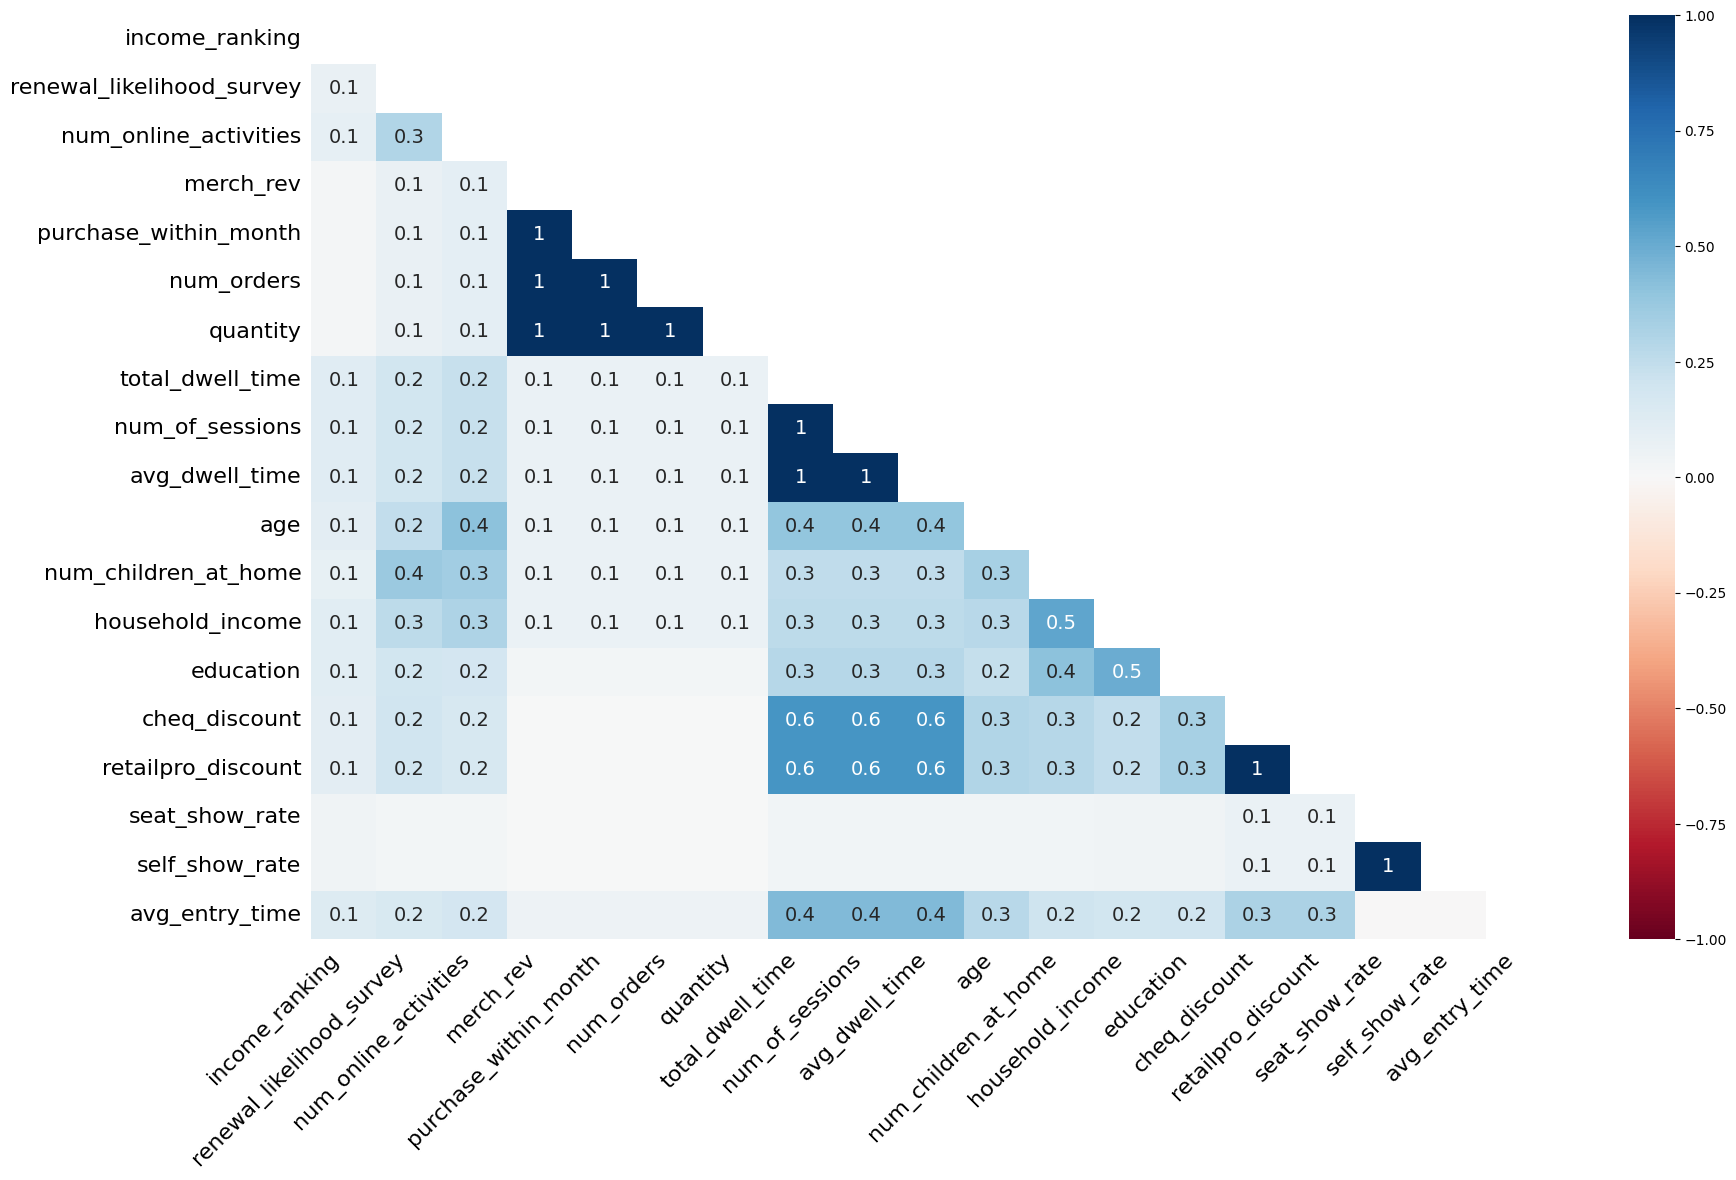

In [8]:
msno.heatmap(df_all)

If missing values are MCAR then you can delete rows. If a large % of a column is missing (and the feature is not significant) then you can delete columns.

Else impute:

For non time series: Can impute with mean, median, mode, etc

For time series: ffill or bfill

In [47]:
# Fill columns w/ null values

df = df_all.copy()

df['income_ranking'] = df['income_ranking'].fillna(df['income_ranking'].mean())

df['renewal_likelihood_survey'] = df['renewal_likelihood_survey'].fillna(df['renewal_likelihood_survey'].mean())

df['num_online_activities'] = df['num_online_activities'].fillna(0)

df['merch_rev'] = df['merch_rev'].fillna(0)

df['purchase_within_month'] = df['purchase_within_month'].fillna(0)

df['num_orders'] = df['num_orders'].fillna(0)

df['quantity'] = df['quantity'].fillna(0)

df['total_dwell_time'] = df['total_dwell_time'].fillna(0)

df['num_of_sessions'] = df['num_of_sessions'].fillna(0)

df['avg_dwell_time'] = df['avg_dwell_time'].fillna(0)

df['age'] = df['age'].fillna(df['age'].mean())

df['num_children_at_home'] = df['num_children_at_home'].fillna(df['num_children_at_home'].mean())

df['household_income'] = df['household_income'].fillna(df['household_income'].mean())

df['education'] = df['education'].fillna(df['education'].mean())

df['retailpro_discount'] = df['retailpro_discount'].fillna(0)

df['cheq_dicount'] = df['cheq_dicount'].fillna(0)

df['self_show_rate'] = df['self_show_rate'].fillna(0)

df['seat_show_rate'] = df['seat_show_rate'].fillna(0)

df['avg_entry_time'] = df['avg_entry_time'].fillna(0)

2: Feature Evaluation

In [23]:
# correlation coefficients

def create_correlation_matrix(df):

    matrix = df.corr()

    cols = df.columns

    fig, ax = plt.subplots()
    im = ax.imshow(matrix, cmap = 'RdYlGn')

    ax.set_xticks(range(len(cols)), labels=cols,
                rotation=45, ha="right", rotation_mode="anchor")
    ax.set_yticks(range(len(cols)), labels=cols)

    for i, ii in zip(range(len(cols)), cols):
        for j, jj in zip(range(len(cols)),cols):
            text = ax.text(j, i, round(matrix[ii][jj],2),
                        ha="center", va="center")

    return plt

In [32]:
df_all_2324 = df_all[df_all['season'] == '2023-24'].drop(['season'], axis = 1)

<module 'matplotlib.pyplot' from 'c:\\Users\\riffere\\Documents\\pandas_party\\venv\\Lib\\site-packages\\matplotlib\\pyplot.py'>

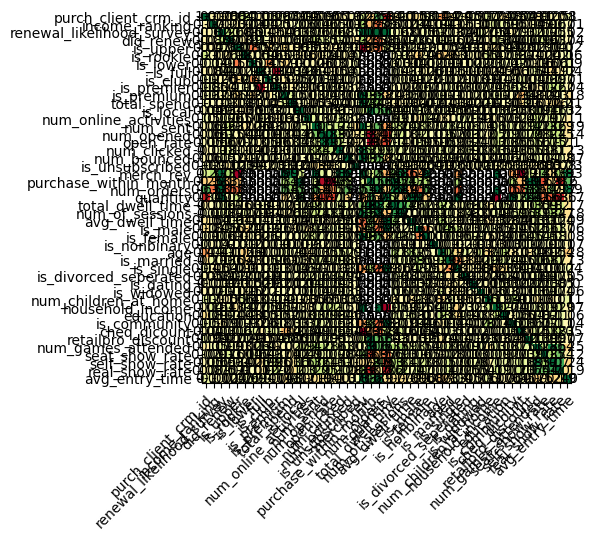

In [34]:
create_correlation_matrix(df_all_2324)

Interaction Variables: Attendance, Spen, Affinity, Engagement scores (comhbine highly coorelated variables or variables of similar field to create one variable)

Step 3: Training & Running Model

In [ ]:
# create monte carlo simulation for model

def run_log_reg(ticket_type, x_train, x_test, y, acct_ids, num_simulations):

    ss = StandardScaler()
    x_train_scaler = ss.fit_transform(x_train)
    x_test_scaler = ss.fit_transform(x_test)

    if ticket_type == 'Full':
        weights = [1,1,2,2,1,1,1,1,2]
    else:
        weights = [1,1,1.5,1.5,1,1,1,1,2]
    x_train_scaler = x_train_scaler*weights
    x_test_scaler = x_test_scaler*weights

    predicted_probs = np.zeros((x_test_scaler.shape[0], num_simulations))

    for i in range(num_simulations):

        logi = LogisticRegression(class_weight='balanced').fit(x_train_scaler, np.array(y))
        predicted_probs[:,i] = logi.predict_proba(x_test_scaler)[:,1]
    
    avg_predicted_probs = np.mean(predicted_probs, axis = 1)

    result_df = x_test
    result_df['avg_predicted_prob'] = avg_predicted_probs
    result_df = pd.concat([acct_ids, result_df], axis = 1)

    return result_df

In [15]:
# run Full model

full_final_df = run_log_reg('Full', x_full_train, x_full_test, y_full, full_acct_ids, 1000)

subtract = [random.uniform(.09, .11) for i in range(len(full_final_df))]

full_final_df['avg_predicted_prob'] = [value - subtract_value if value >= 0.12 else value for value, subtract_value in zip(full_final_df['avg_predicted_prob'], subtract)]

full_final_df['ticket_type'] = 'Full'

c:\Users\riffere\Documents\pandas_party\venv\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\riffere\Documents\pandas_party\venv\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\riffere\Documents\pandas_party\venv\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\riffere\Documents\pandas_party\venv\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was 

Step 4: Model Evaluation

In [51]:
df_2324 = df[df['season'] == '2023-24'].drop(['season'], axis = 1)

y = df_2324['did_renew']

x = df_2324.drop(['purch_client_crm_id', 'did_renew'], axis = 1)

In [52]:
logi = LogisticRegression().fit(x, np.array(y))

predicted = logi.predict(x)

print(classification_report(predicted, y))

              precision    recall  f1-score   support

           0       0.04      0.41      0.07        39
           1       0.99      0.91      0.95      4164

    accuracy                           0.90      4203
   macro avg       0.52      0.66      0.51      4203
weighted avg       0.99      0.90      0.94      4203



c:\Users\riffere\Documents\pandas_party\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [54]:
# Recersive Feature Elimination

selector = RFECV(estimator = LogisticRegression(), step = 1, min_features_to_select=10, scoring = 'accuracy')
selector.fit(x, np.array(y)).n_features_

cv_results = pd.DataFrame(selector.cv_results_)
# plt.figure()
# plt.xlabel("Number of features selected")
# plt.ylabel("Mean test accuracy")
# plt.errorbar(
#     x=cv_results["n_features"],
#     y=cv_results["mean_test_score"],
#     yerr=cv_results["std_test_score"],
# )
# plt.title("Recursive Feature Elimination \nwith correlated features")
# plt.show()

c:\Users\riffere\Documents\pandas_party\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\riffere\Documents\pandas_party\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_

In [ ]:
param_grid = {'C': [0.1, 1, 10, 100],  
              'penalty': ['l1', 'l2', 'elasticnet'], 
              'class_weight' : ['balanced'],
              'solver' : ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']} 

grid = GridSearchCV(LogisticRegression(), param_grid, refit = True, verbose = 3,n_jobs=-1) 
   
# fitting the model for grid search 
grid.fit(x, y) 
 
# print best parameter after tuning 
print(grid.best_params_) 
grid_predictions = grid.predict(x) 
   
# print classification report 
print(classification_report(y, grid_predictions)) 

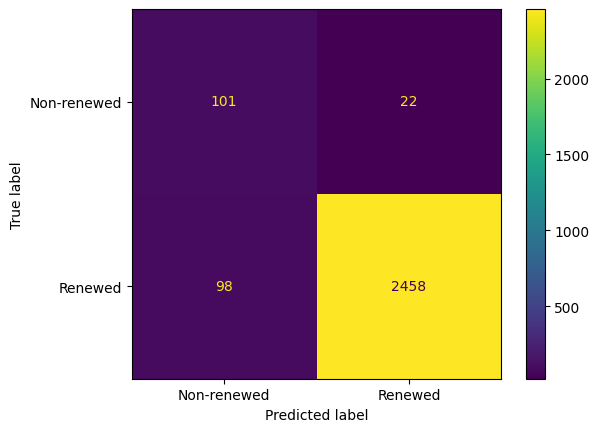

In [47]:
# AUC ROC

roc_auc_score(predicted, y_premier)

# Confusion Matrix

disp = ConfusionMatrixDisplay(confusion_matrix(predicted, y_premier), display_labels= ['Non-renewed', 'Renewed'])

disp.plot()

plt.show()

Step 5: Model Tuning